In [1]:
!make docker-image > /dev/null 2>&1

In [2]:
!CONTAINER_CMD="bash -lc 'make install-ycsb'" make docker > /dev/null 2>&1

In [3]:
from pathlib import Path
import pexpect
import os
import time

""" Collector class has helper methods to interact with kermit"""
class Collector: 
    def __init__(self, config: Path):
        self.env = os.environ.copy()
        self.env["INTERACTIVE"] = "it"
        self.env["CONTAINER_CMD"] = f"bash -lc 'KERNMLOPS_CONFIG_FILE={config} make collect-data'"
        self.collect_process : pexpect.spawn | None = None

    def start_collection(self, logfile=None):
        self.collect_process = pexpect.spawn("make docker", env=self.env, timeout=None, logfile=logfile)
        self.collect_process.expect_exact(["Started benchmark"])

    def _after_run_generate_file_data() -> dict[str, list[Path]]:
        start_path : Path = Path("./data")
        list_of_collect_id_dirs = start_path.glob("*/*/*")
        latest_collect_id = max(list_of_collect_id_dirs, key=os.path.getctime)
        list_of_files = latest_collect_id.glob("*.*.parquet")
        output = {}
        for f in list_of_files:
            index = str(f).removeprefix(str(f.parent) + "/").split(".")[0]
            if index not in output.keys():
                output[index] = []
            output[index].append(f)
        return output
        
    def wait(self) -> int:
        if self.collect_process is None:
            return
        self.collect_process.expect([pexpect.EOF])
        self.collect_process.wait()
        return Collector._after_run_generate_file_data()
        
    def stop_collection(self):
        if self.collect_process is None:
            return
        self.collect_process.sendline("END")
        return self.wait()

There are two ways to run kermit:
- With the raw config
- With a pre-programmed benchmark config

In [4]:
import subprocess
import sys
collect = Collector("./config/raw_overrides.yaml")
# This creates a raw collector, I suggest looking into this file to learn more

w = open("hello.txt", "bw")
collect.start_collection(logfile=w)
print("Collection has started")
# Start collection

f = open("blah.txt", "w")
bench_test = subprocess.Popen(["cat", "defaults.yaml"], stdout=f)
bench_test.wait()
# Run benchmark application

print("Exit application")
raw_coll_info = collect.stop_collection()
print(raw_coll_info)
# Stop the Collector

Collection has started
Exit application
{'dtlb_misses': [PosixPath('data/curated/faux/212f9b40-a393-48c9-88bf-f65f75d69380/dtlb_misses.end.parquet')], 'block_io': [PosixPath('data/curated/faux/212f9b40-a393-48c9-88bf-f65f75d69380/block_io.end.parquet')], 'file_data': [PosixPath('data/curated/faux/212f9b40-a393-48c9-88bf-f65f75d69380/file_data.end.parquet')], 'system_info': [PosixPath('data/curated/faux/212f9b40-a393-48c9-88bf-f65f75d69380/system_info.end.parquet')], 'dtlb_walk_duration': [PosixPath('data/curated/faux/212f9b40-a393-48c9-88bf-f65f75d69380/dtlb_walk_duration.end.parquet')], 'process_metadata': [PosixPath('data/curated/faux/212f9b40-a393-48c9-88bf-f65f75d69380/process_metadata.end.parquet')], 'tlb_flushes': [PosixPath('data/curated/faux/212f9b40-a393-48c9-88bf-f65f75d69380/tlb_flushes.end.parquet')], 'itlb_misses': [PosixPath('data/curated/faux/212f9b40-a393-48c9-88bf-f65f75d69380/itlb_misses.end.parquet')], 'quanta_runtime': [PosixPath('data/curated/faux/212f9b40-a393-48c

In [16]:
collect = Collector("./config/start_overrides.yaml")
# This is a simple redis benchmark config

w = open("hello.txt", "bw")
collect.start_collection(logfile=w)
# Start collection

start_coll_info = collect.wait()
#Wait for collector to finish

In [17]:
print(raw_coll_info.keys())
print(start_coll_info.keys())

dict_keys(['dtlb_misses', 'block_io', 'file_data', 'system_info', 'dtlb_walk_duration', 'process_metadata', 'tlb_flushes', 'itlb_misses', 'quanta_runtime', 'memory_usage', 'process_trace', 'quanta_queued_time'])
dict_keys(['dtlb_misses', 'block_io', 'file_data', 'system_info', 'dtlb_walk_duration', 'process_metadata', 'tlb_flushes', 'itlb_misses', 'quanta_runtime', 'memory_usage', 'process_trace', 'quanta_queued_time'])


Now let's try to examine some of the system information from this.
I use polars, you can use whatever you like as far as data frames go, so long as they can read parquet files.

In [7]:
import polars as pl
df = pl.read_parquet(raw_coll_info["process_trace"])
print(df.columns)

['pid', 'tgid', 'ts_ns', 'name', 'cap_type', 'collection_id']


In [8]:
import polars as pl
df = pl.read_parquet(raw_coll_info["process_trace"])

def filter_process_trace(process_trace_df: pl.DataFrame) -> pl.DataFrame :
    df = process_trace_df
    # Filter just the processes
    df = df.filter(pl.col("tgid") == pl.col("pid")).drop("collection_id")

    # Find the last name of each process
    start_df = df.sort(pl.col("ts_ns"), descending = True)
    helper_dict = {}
    for row in start_df.iter_rows():
        pid = row[0]
        comm = row[3]
        if pid in helper_dict.keys() or comm == "": 
            continue
        helper_dict[pid] = comm

    # Separate the start and end
    full_df = start_df.with_columns(pl.col("pid").map_elements(lambda x : helper_dict.get(x, ""), return_dtype=str).alias("full_name"))
    full_df = full_df.drop(["tgid", "name"])
    start_df = full_df.filter(pl.col("cap_type") == "start").rename({"ts_ns": "start_ns"}).drop("cap_type")
    end_df = full_df.filter(pl.col("cap_type") == "end").rename({"ts_ns": "end_ns"}).drop(["cap_type", "full_name"])

    # Join them to get the process table
    return start_df.join(end_df, "pid")



In [9]:
filter_process_trace(pl.read_parquet(raw_coll_info["process_trace"]))

pid,start_ns,full_name,end_ns
i64,i64,str,i64
7874,6036613447330,"""cat""",6036692064915


In [10]:
filter_process_trace(pl.read_parquet(start_coll_info["process_trace"]))

pid,start_ns,full_name,end_ns
i64,i64,str,i64
8232,6075487985815,"""redis-server""",6109364321105
8606,6109333138180,"""redis-cli""",6109336152435
8471,6102535523560,"""ycsb""",6109204057919
8575,6108873526876,"""java""",6109170580728
8473,6102593592651,"""java""",6108798545024
…,…,…,…
8245,6077179289120,"""ls""",6077258838613
8244,6077177466114,"""uname""",6077178920140
8242,6077095669074,"""pwd""",6077103677344


In [11]:
import polars as pl

def filter_process_trace(process_trace_df: pl.DataFrame) -> pl.DataFrame :
    df = process_trace_df
    # Filter just the processes
    df = df.filter(pl.col("tgid") == pl.col("pid")).drop("collection_id")

    # Find the last name of each process
    start_df = df.sort(pl.col("ts_ns"), descending = True)
    helper_dict = {}
    for row in start_df.iter_rows():
        pid = row[0]
        comm = row[3]
        if pid in helper_dict.keys() or comm == "": 
            continue
        helper_dict[pid] = comm

    # Separate the start and end
    full_df = start_df.with_columns(pl.col("pid").map_elements(lambda x : helper_dict.get(x, ""), return_dtype=str).alias("full_name"))
    full_df = full_df.drop(["tgid", "name"])
    start_df = full_df.filter(pl.col("cap_type") == "start").rename({"ts_ns": "start_ns"}).drop("cap_type")
    end_df = full_df.filter(pl.col("cap_type") == "end").rename({"ts_ns": "end_ns"}).drop(["cap_type", "full_name"])

    # Join them to get the process table
    combined_df = start_df.join(end_df, "pid")
    return combined_df.with_columns((pl.col("end_ns") - pl.col("start_ns")).alias("duration"))

def process_trace_start_end_ts(process_trace_df: pl.DataFrame, proc_name: str, index: int) ->(int, int, int):
    trace_df = filter_process_trace(process_trace_df).sort(pl.col("start_ns"))
    df = trace_df.filter(pl.col("full_name") == proc_name)
    print(df)
    df = df[index]
    pid = df["pid"][0]
    start_ns = df["start_ns"][0]
    end_ns = df["end_ns"][0]
    return pid, start_ns, end_ns

def clean_rss_pid(rss_df: pl.DataFrame, pid: int) -> pl.DataFrame:
    df = rss_df.drop(["pid", "collection_id"]).sort(pl.col("ts_ns"))
    df = df.filter(pl.col("tgid") == pid)
    df = df.with_columns(pl.when(pl.col("member") == "MM_FILEPAGES")
                     .then(pl.col("count"))
                     .otherwise(None)
                     .fill_null(strategy="forward")
                     .fill_null(strategy="backward")
                     .alias("file"))
    df = df.with_columns(pl.when(pl.col("member") == "MM_ANONPAGES")
                     .then(pl.col("count"))
                     .otherwise(None)
                     .fill_null(strategy="forward")
                     .fill_null(strategy="backward")
                     .alias("anon"))
    df = df.with_columns(pl.when(pl.col("member") == "MM_SWAPENTS")
                     .then(pl.col("count"))
                     .otherwise(None)
                     .fill_null(strategy="forward")
                     .fill_null(strategy="backward")
                     .alias("swap"))
    df = df.drop(["member", "count"])
    zero_df = pl.DataFrame({"tgid": pid, "ts_ns" : -1, "file" : 0, "anon": 0, "swap": 0})
    df = pl.concat([df, zero_df]).sort("ts_ns")
    df = df.fill_null(strategy="forward")
    df = df.filter(pl.col("ts_ns") >= 0)
    df = df.with_columns((pl.col("file") + pl.col("anon") + pl.col("swap")).alias("count"))
    df = df.drop(["file", "anon", "swap"])
    return df

def filter_rss_with_ts(rss_trace_df: pl.DataFrame, start: int, end: int):
    print(start, end)
    new_frame_dict = {}
    for column_name in rss_trace_df.columns:
        new_frame_dict[column_name] = [None, None]
    new_frame_dict["ts_ns"] = [start, end]
    df = rss_trace_df.vstack(pl.DataFrame(new_frame_dict))
    df = df.sort(pl.col("ts_ns")).fill_null(strategy="forward").fill_null(strategy="backward")
    return df.filter(pl.col("ts_ns").is_between(start, end, closed='both'))

def get_proper_rss(proc_path: Path, rss_path: Path, rss_name: str, rss_ind: int, runner_name: str, runner_ind: int, tag:str):
    proc_trace_df = pl.read_parquet(proc_path)
    rss_df = pl.read_parquet(rss_path)

    _, start, end = process_trace_start_end_ts(proc_trace_df, runner_name, runner_ind)
    pid, _, _ = process_trace_start_end_ts(proc_trace_df, rss_name, rss_ind)
    clean_rss_df = filter_rss_with_ts(clean_rss_pid(rss_df, pid), start, end)
    return clean_rss_df.with_columns((pl.col("ts_ns") - pl.min("ts_ns")).alias("norm_ts_ns")).with_columns(pl.lit(tag).alias('policy'))

from pathlib import Path
from plotnine import ggplot, aes, geom_line, geom_point, labs

def create_graph(inputs: [(str, dict[str, Path])], proc_tag: str, proc_ind: int, time_proc_tag: str, time_proc_index: int, title: str) -> None:
    df = pl.DataFrame()
    for (tag, filedict) in inputs:
        append_df = get_proper_rss(filedict["process_trace"],
                                   filedict["mm_rss_stat"],
                                   proc_tag, proc_ind,
                                   time_proc_tag,
                                   time_proc_index,
                                   tag).drop(["tgid", "ts_ns"])
        df = pl.concat([df, append_df])
    df = df.with_columns((pl.col("norm_ts_ns") / (10**9)/ 60).alias("norm_ts_mins"))
    plt0 = (ggplot(df)
            + aes("norm_ts_mins", y="count", colour="policy")
            + geom_point()
            + geom_line()
            + labs(x="Time (mins)",
                   y="4kB Pages",
                   title=title)
           )
    return plt0

In [18]:
collect = Collector("./config/redis_never.yaml")
collect.start_collection(None)
redis_never_info = collect.wait()
collect = Collector("./config/redis_madvise.yaml")
collect.start_collection(None)
redis_madvise_info = collect.wait()
collect = Collector("./config/redis_always.yaml")
collect.start_collection(None)
redis_always_info = collect.wait()

In [19]:
from IPython.display import Image, display
plt = create_graph([("4k", redis_never_info),
                    ("madvise", redis_madvise_info),
                    ("thp", redis_always_info)],
                   "redis-server", 0, 
                   "redis-server", 0,
                   "Redis driven by YCSB with Insertions and Deletes using Jemalloc")
plt.save("deletes-redis.png")

shape: (1, 5)
┌───────┬────────────────┬──────────────┬────────────────┬─────────────┐
│ pid   ┆ start_ns       ┆ full_name    ┆ end_ns         ┆ duration    │
│ ---   ┆ ---            ┆ ---          ┆ ---            ┆ ---         │
│ i64   ┆ i64            ┆ str          ┆ i64            ┆ i64         │
╞═══════╪════════════════╪══════════════╪════════════════╪═════════════╡
│ 15348 ┆ 19333078333836 ┆ redis-server ┆ 19385759467883 ┆ 52681134047 │
└───────┴────────────────┴──────────────┴────────────────┴─────────────┘
shape: (1, 5)
┌───────┬────────────────┬──────────────┬────────────────┬─────────────┐
│ pid   ┆ start_ns       ┆ full_name    ┆ end_ns         ┆ duration    │
│ ---   ┆ ---            ┆ ---          ┆ ---            ┆ ---         │
│ i64   ┆ i64            ┆ str          ┆ i64            ┆ i64         │
╞═══════╪════════════════╪══════════════╪════════════════╪═════════════╡
│ 15348 ┆ 19333078333836 ┆ redis-server ┆ 19385759467883 ┆ 52681134047 │
└───────┴──────────────

/users/moogloof/KernMLOps/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/moogloof/KernMLOps/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: deletes-redis.png


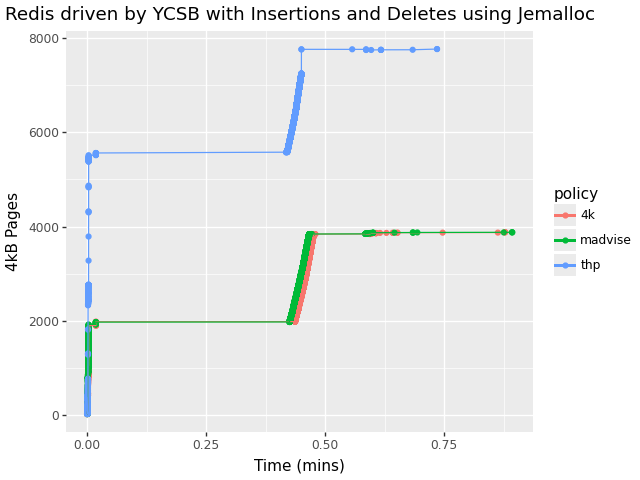

In [20]:
Image(filename="./deletes-redis.png")

In [21]:
collect = Collector("./config/redis_always.yaml")
collect.start_collection(None)
redis_always_info = collect.wait()
collect = Collector("./config/redis_always_hp.yaml")
collect.start_collection(None)
redis_always_hp_info = collect.wait()

In [22]:
plt = create_graph([("collapse", redis_always_hp_info),
                    ("no-collapse", redis_always_info)],
                   "redis-server", 0, 
                   "redis-server", 0,
                   "Collapse vs No-Collapse")
plt.save("collapse-redis.png")

shape: (1, 5)
┌───────┬────────────────┬──────────────┬────────────────┬─────────────┐
│ pid   ┆ start_ns       ┆ full_name    ┆ end_ns         ┆ duration    │
│ ---   ┆ ---            ┆ ---          ┆ ---            ┆ ---         │
│ i64   ┆ i64            ┆ str          ┆ i64            ┆ i64         │
╞═══════╪════════════════╪══════════════╪════════════════╪═════════════╡
│ 19142 ┆ 23179426618611 ┆ redis-server ┆ 23225239246323 ┆ 45812627712 │
└───────┴────────────────┴──────────────┴────────────────┴─────────────┘
shape: (1, 5)
┌───────┬────────────────┬──────────────┬────────────────┬─────────────┐
│ pid   ┆ start_ns       ┆ full_name    ┆ end_ns         ┆ duration    │
│ ---   ┆ ---            ┆ ---          ┆ ---            ┆ ---         │
│ i64   ┆ i64            ┆ str          ┆ i64            ┆ i64         │
╞═══════╪════════════════╪══════════════╪════════════════╪═════════════╡
│ 19142 ┆ 23179426618611 ┆ redis-server ┆ 23225239246323 ┆ 45812627712 │
└───────┴──────────────

/users/moogloof/KernMLOps/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/moogloof/KernMLOps/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: collapse-redis.png
